<h1 style="text-align: center">
Deep Learning HW3 </br>
Q1
</h1>


### Full Name: Hesam Hosseini
### Student ID: 400101034

### loading and importing libraries

In [2]:
!pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 44.5 MB/s eta 0:00:00


In [56]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import rdkit
import re
from rdkit import Chem
from IPython.display import display
from rdkit.Chem import Draw
from rdkit.Chem import Descriptors
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader,Dataset,ConcatDataset
import torch.nn as nn
from sklearn.model_selection import train_test_split

In [57]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [58]:
df = pd.read_csv('/content/drive/MyDrive/Deep_Learning/HW4/Q1/BBBP.csv')

In [59]:
df

,num,name,p_np,smiles
0,1,Propanolol,1,[Cl].CC(C)NCC(O)COc1cccc2ccccc12
1,2,Terbutylchlorambucil,1,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl
2,3,40730,1,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...
3,4,24,1,C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C
4,5,cloxacillin,1,Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)...
...,...,...,...,...
2045,2049,licostinel,1,C1=C(Cl)C(=C(C2=C1NC(=O)C(N2)=O)[N+](=O)[O-])Cl
2046,2050,ademetionine(adenosyl-methionine),1,[C@H]3([N]2C1=C(C(=NC=N1)N)N=C2)[C@@H]([C@@H](...
2047,2051,mesocarb,1,[O+]1=N[N](C=C1[N-]C(NC2=CC=CC=C2)=O)C(CC3=CC=...
2048,2052,tofisoline,1,C1=C(OC)C(=CC2=C1C(=[N+](C(=C2CC)C)[NH-])C3=CC...


## 0) getting familiar with Smiles

here is two usefull site which I used to undestand smiles notation

References: [Publication](https://pubs.acs.org/doi/pdf/10.1021/ci00057a005?casa_token=vk_RJ_Dk2TMAAAAA:kxjUDIVIALIW5qVJD8WxqmHucn8Ht3K9PTvErhGqlNaO4HtrzbZjbcU1DQdXvUAGM5fyyBnRFWPkP89u6Q)<br>
A tutorial in [Daylight website](https://www.daylight.com/meetings/summerschool98/course/dave/smiles-intro.html)


* SMILES encodes a molecular structure. It consists of a series of characters containing no spaces. Example: O=C(C)Oc1ccccc1C(=O)O
* SMILES notation is widely used in cheminformatics, molecular modeling, and drug design.

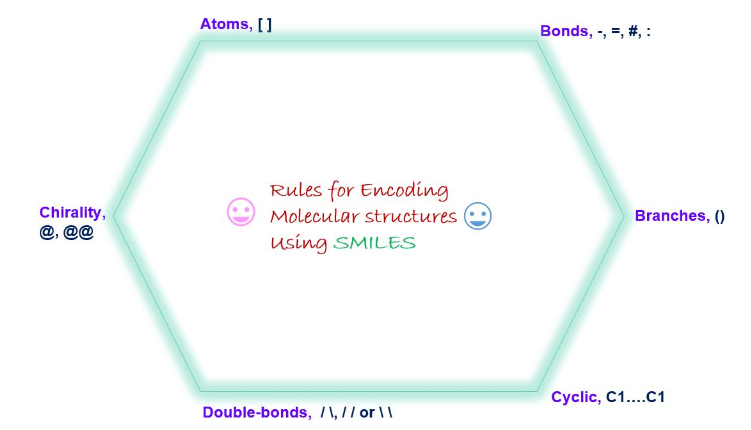

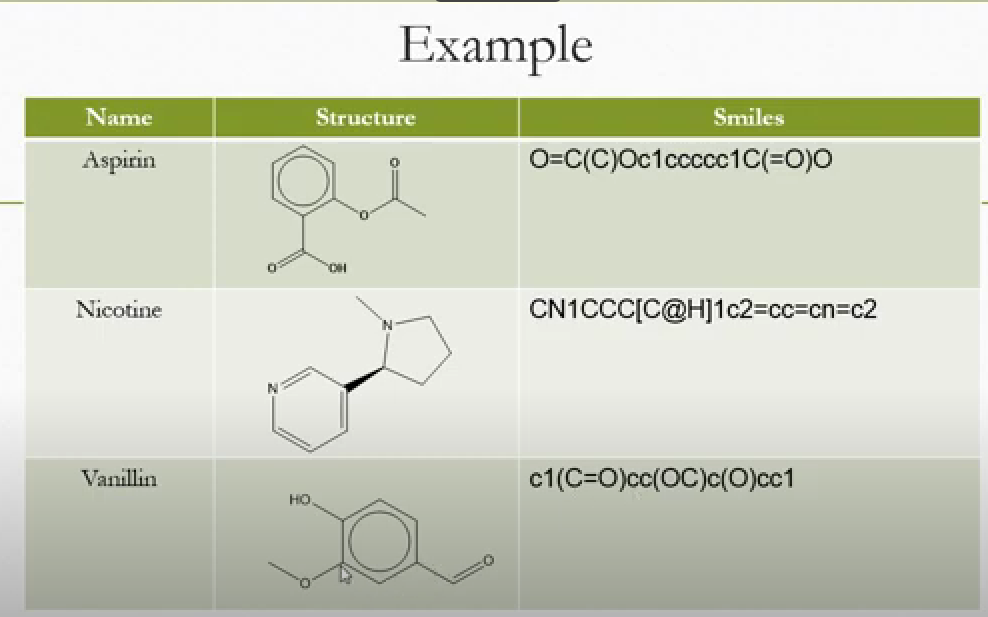

## A) getting familiar with data-set

### lenght of strings in data-set:

In [60]:
df['smiles_len'] = df['smiles'].apply(len)

In [61]:
df

,num,name,p_np,smiles,smiles_len
0,1,Propanolol,1,[Cl].CC(C)NCC(O)COc1cccc2ccccc12,32
1,2,Terbutylchlorambucil,1,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl,40
2,3,40730,1,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...,50
3,4,24,1,C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C,32
4,5,cloxacillin,1,Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)...,66
...,...,...,...,...,...
2045,2049,licostinel,1,C1=C(Cl)C(=C(C2=C1NC(=O)C(N2)=O)[N+](=O)[O-])Cl,47
2046,2050,ademetionine(adenosyl-methionine),1,[C@H]3([N]2C1=C(C(=NC=N1)N)N=C2)[C@@H]([C@@H](...,87
2047,2051,mesocarb,1,[O+]1=N[N](C=C1[N-]C(NC2=CC=CC=C2)=O)C(CC3=CC=...,53
2048,2052,tofisoline,1,C1=C(OC)C(=CC2=C1C(=[N+](C(=C2CC)C)[NH-])C3=CC...,63


<Axes: xlabel='smiles_len', ylabel='Count'>

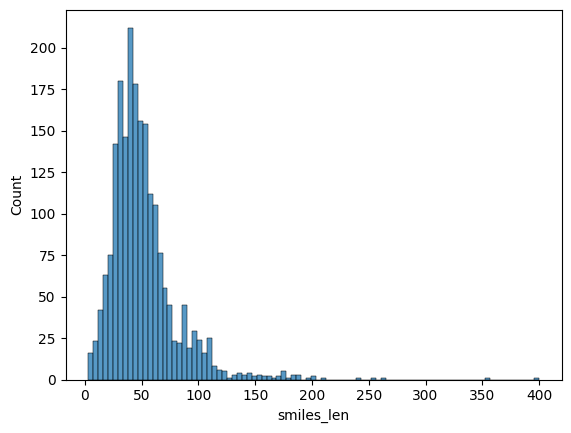

In [62]:
sns.histplot(df['smiles_len'])

by looking at hitsplot we can understand that most of our data consist of strings with len 55

and this data-set is right skeewed and there are some outlier

<Axes: xlabel='smiles_len', ylabel='Count'>

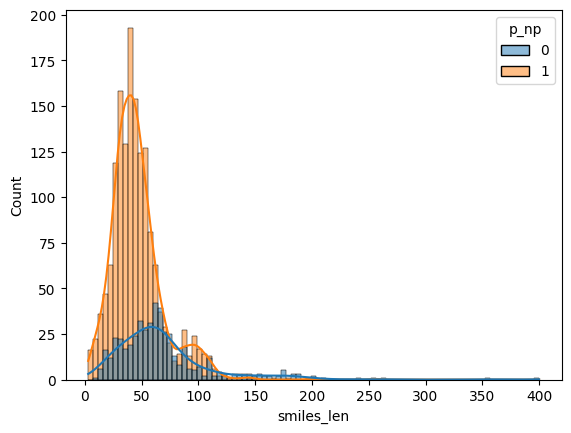

In [63]:
sns.histplot(data = df , x = 'smiles_len',hue='p_np',kde=True)

In [64]:
l1 = len(df[df['p_np']==1])
print(l1)
df[df['p_np']==1]['smiles_len'].mean()

1567


46.29100191448628

In [65]:
l2 = len(df[df['p_np']==0])
print(l2)
df[df['p_np']==0]['smiles_len'].mean()

483


68.28985507246377

In [66]:
print(l1/(l1+l2)*100)

76.4390243902439


as you can see most of our data has p_np of 1 (76%)

and the mean of 0 datas are a little ahead of p_np 0 and there are more outliers in p_np 0 than p_np 1

In [67]:
max_len = df['smiles_len'].max()
max_len

400

In [68]:
len(df['smiles'].value_counts())

2050

### tokenizing:

In [69]:
import re

SMI_REGEX_PATTERN = r"""(\[[^\]]+]|Br?|Cl?|N|O|S|P|F|I|b|c|n|o|s|p|\(|\)|\.|=|#|-|\+|\\|\/|:|~|@|\?|>>?|\*|\$|\%[0-9]{2}|[0-9])"""
regex = re.compile(SMI_REGEX_PATTERN)

def tokenizer(smiles_string):
  tokens = [token for token in regex.findall(smiles_string)]
  return tokens
sample = df['smiles'][np.random.randint(len(df)-1)]
print('sample: ',sample)
print(f'sample len {len(sample)}')
print(f'tokenized sample {str(tokenizer(sample))}')
print(f'tokenized len {len(tokenizer(sample))}')

sample:  C1=CC=CC2=C1N(C3=C(C=C2)C=CC=C3)CCCN(C)C
sample len 40
tokenized sample ['C', '1', '=', 'C', 'C', '=', 'C', 'C', '2', '=', 'C', '1', 'N', '(', 'C', '3', '=', 'C', '(', 'C', '=', 'C', '2', ')', 'C', '=', 'C', 'C', '=', 'C', '3', ')', 'C', 'C', 'C', 'N', '(', 'C', ')', 'C']
tokenized len 40


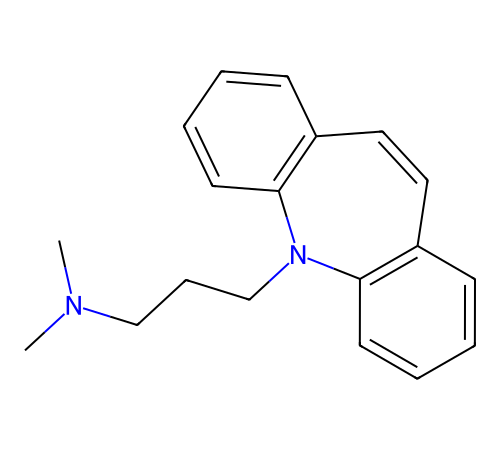

In [70]:
# draw expample of data set
taxol = Chem.MolFromSmiles(sample)
Draw.MolToImage(taxol, size=(500, 450))

In [71]:
def build_vocab(data):
  vocab_ = set()
  smiles = list(data['smiles'])

  for ex in smiles:
    for letter in tokenizer(ex):
      vocab_.add(letter)

  vocab={}
  vocab['<PAD>'] = 0
  vocab['<UNK>'] = 1
  for i,letter in enumerate(vocab_):
    vocab[letter]=i+2
  inv_dict= {num: char for char, num in vocab.items()}
  inv_dict[0] = ''
  return vocab, inv_dict

In [72]:
vocab,inv_dict = build_vocab(df)

In [73]:
vocab

{'<PAD>': 0,
 '<UNK>': 1,
 '[N@]': 2,
 '[N+]': 3,
 'N': 4,
 '#': 5,
 '[Na]': 6,
 '[N]': 7,
 '[OH-]': 8,
 'I': 9,
 '(': 10,
 '[C@@H]': 11,
 '[CH2-]': 12,
 '[o+]': 13,
 'Cl': 14,
 'c': 15,
 '[nH+]': 16,
 '%13': 17,
 '[C@H]': 18,
 '[S]': 19,
 '[NH2]': 20,
 '[Ca++]': 21,
 '[CH-]': 22,
 '\\': 23,
 '7': 24,
 '[Cl-]': 25,
 'Br': 26,
 '[N-]': 27,
 'C': 28,
 '5': 29,
 '3': 30,
 '8': 31,
 '[NH+]': 32,
 '9': 33,
 'F': 34,
 '.': 35,
 '4': 36,
 ')': 37,
 '[C@@]': 38,
 '[O-]': 39,
 '%10': 40,
 '[nH]': 41,
 '[H]': 42,
 '[NH3+]': 43,
 '%14': 44,
 '[S+]': 45,
 '[N@@]': 46,
 '[NH2+]': 47,
 '[P]': 48,
 'O': 49,
 '[NH-]': 50,
 '%11': 51,
 '=': 52,
 'o': 53,
 '[C@]': 54,
 '%12': 55,
 '[S@]': 56,
 '[Cl]': 57,
 '1': 58,
 '[NH]': 59,
 '[Br-]': 60,
 'B': 61,
 'S': 62,
 '[C-]': 63,
 '/': 64,
 '6': 65,
 '[H+]': 66,
 '[n+]': 67,
 '2': 68,
 '[O+]': 69,
 'n': 70,
 's': 71,
 '[Na+]': 72}

In [74]:
len(vocab)

73

In [75]:
vocab_count = vocab.copy()
for token in vocab_count:
  vocab_count[token] = 0

In [76]:
def token_freq(ser,vocab):
  vocab_count = vocab.copy()
  for string in ser:
    tokens = tokenizer(string)
    for token in tokens:
      if token in vocab_count.keys():
        vocab_count[token] +=1
      else:
        vocab_count['<UNK>'] +=1
  return vocab_count

tot_freq = token_freq(df['smiles'],vocab_count)
tot_freq_1 = token_freq(df[df['p_np']==0]['smiles'],vocab_count)
tot_freq_0 = token_freq(df[df['p_np']==1]['smiles'],vocab_count)

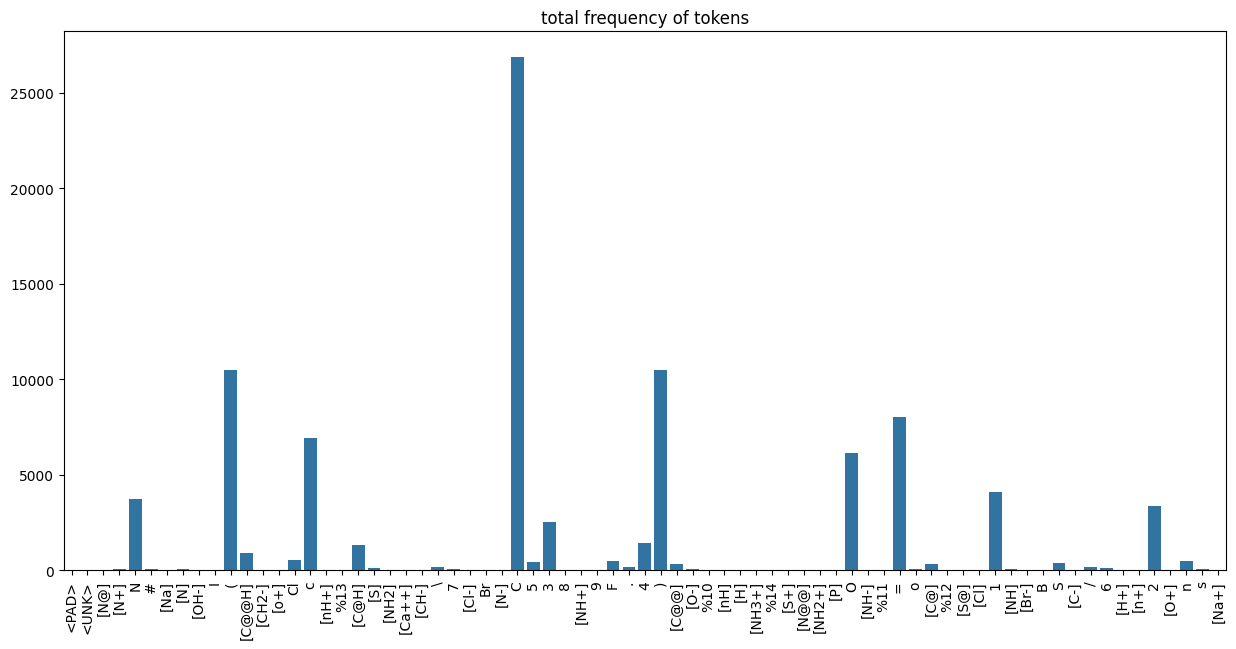

In [77]:
fig, ax = plt.subplots(figsize=(15, 7))
sns.barplot(tot_freq,).set(title='total frequency of tokens');
plt.xticks(rotation=90);

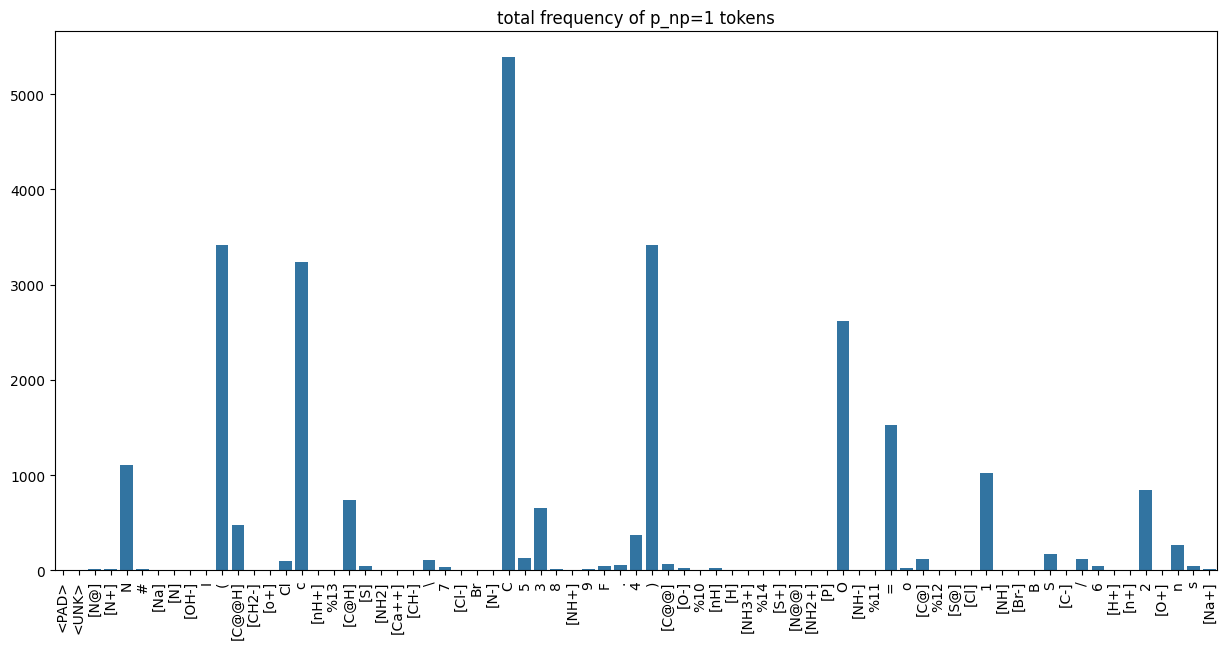

In [78]:
fig, ax = plt.subplots(figsize=(15, 7))
sns.barplot(tot_freq_1).set(title='total frequency of p_np=1 tokens');
plt.xticks(rotation=90);

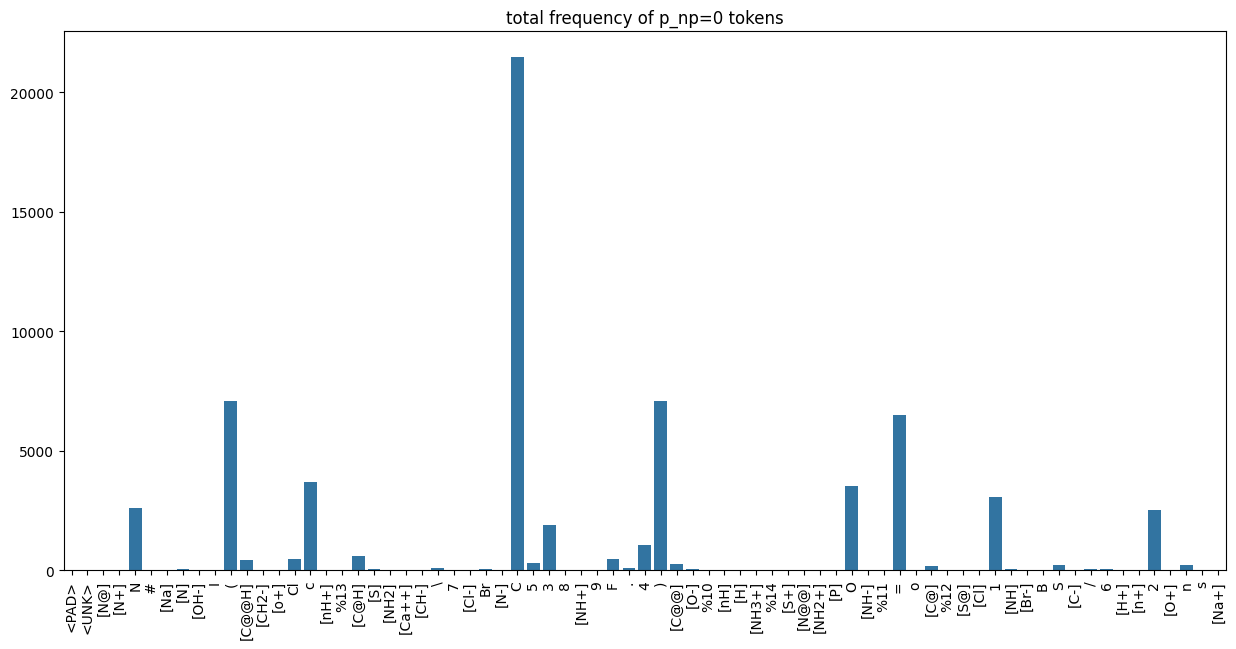

In [79]:
fig, ax = plt.subplots(figsize=(15, 7))
sns.barplot(tot_freq_0).set(title='total frequency of p_np=0 tokens');
plt.xticks(rotation=90);

## B) One_hot and Training FC

### one_hot

In [80]:
def make_one_hot(data,vocab,max_len=120):
  data_one_hot=np.zeros((len(data),max_len,len(vocab)))
  for i, smiles in enumerate(data):

    smiles = tokenizer(smiles)
    smiles = smiles[:max_len] +['<PAD>']*(max_len-len(smiles))

    for j,letter in enumerate(smiles):
      if letter in vocab.keys():
        data_one_hot[i,j,vocab[letter]] = 1
      else:
        data_one_hot[i,j,vocab['<UNK>']] = 1
  return data_one_hot

In [81]:
vocab,inv_dict = build_vocab(df)
print("Vocab",vocab)
print("Vocab Size",len(vocab))

# data_one_hot = make_one_hot(df['smiles'],vocab,max_len=len(vocab))
train_df , test_df = train_test_split(df, test_size=0.2, random_state=42)
X_train = make_one_hot(train_df['smiles'],vocab,max_len=len(vocab))
X_test = make_one_hot(test_df['smiles'],vocab,max_len=len(vocab))
y_train = train_df['p_np'].values
y_test = test_df['p_np'].values

Vocab {'<PAD>': 0, '<UNK>': 1, '[N@]': 2, '[N+]': 3, 'N': 4, '#': 5, '[Na]': 6, '[N]': 7, '[OH-]': 8, 'I': 9, '(': 10, '[C@@H]': 11, '[CH2-]': 12, '[o+]': 13, 'Cl': 14, 'c': 15, '[nH+]': 16, '%13': 17, '[C@H]': 18, '[S]': 19, '[NH2]': 20, '[Ca++]': 21, '[CH-]': 22, '\\': 23, '7': 24, '[Cl-]': 25, 'Br': 26, '[N-]': 27, 'C': 28, '5': 29, '3': 30, '8': 31, '[NH+]': 32, '9': 33, 'F': 34, '.': 35, '4': 36, ')': 37, '[C@@]': 38, '[O-]': 39, '%10': 40, '[nH]': 41, '[H]': 42, '[NH3+]': 43, '%14': 44, '[S+]': 45, '[N@@]': 46, '[NH2+]': 47, '[P]': 48, 'O': 49, '[NH-]': 50, '%11': 51, '=': 52, 'o': 53, '[C@]': 54, '%12': 55, '[S@]': 56, '[Cl]': 57, '1': 58, '[NH]': 59, '[Br-]': 60, 'B': 61, 'S': 62, '[C-]': 63, '/': 64, '6': 65, '[H+]': 66, '[n+]': 67, '2': 68, '[O+]': 69, 'n': 70, 's': 71, '[Na+]': 72}
Vocab Size 73


In [82]:
X_train.shape

(1640, 73, 73)

In [83]:
# strings = ''
# for num in df['smiles']:
#   strings+=num

In [84]:
# uniq_str = np.unique(list(strings))
# uniq_str

In [85]:
# def one_hot_encoder(s):
#   return (uniq_str == s).astype(int)
# def smile_coder(text):
#   vec = np.zeros((max_len,len(uniq_str)))
#   for i,s in enumerate(text):
#     # print(np.count_nonzero(one_hot_encoder(s)))
#     vec[i,:] = one_hot_encoder(s)

#   vec = vec.flatten()

#   return vec

In [86]:
# len(df.iloc[1]['smiles'])

In [87]:
# np.count_nonzero((smile_coder(df.iloc[1]['smiles'])))

In [88]:
# X = np.zeros((2050,15600))
# for i,text in enumerate(df['smiles']):
#   X[i,:] = smile_coder(text)
# X.shape

In [89]:
# X_data = data_one_hot.reshape(data_one_hot.shape[0],-1)
# X_data.shape

### data_loader

In [139]:

# y = df['p_np'].values
# X = data_one_hot.reshape(y.shape[0],-1)
# Split data into training and test sets
# X_train, X_test, y_train, y_test = train_test_split(data_one_hot, y, test_size=0.2, random_state=42)

class Smiles_OneHotcoding_dataSet(Dataset):
    def __init__(self, X, y):
        self.X = X.reshape(X.shape[0],-1)
        self.y = y
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    def __len__(self):
        return len(self.X)

train_set = Smiles_OneHotcoding_dataSet(X_train,y_train)
test_set = Smiles_OneHotcoding_dataSet(X_test,y_test)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=True)

In [140]:
X_samlpe , y_sample = next(iter(train_loader))
X_samlpe.shape , y_sample.shape

(torch.Size([32, 5329]), torch.Size([32]))

In [141]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### training FC

In [93]:
fc_model = nn.Sequential(
    nn.Linear(X_samlpe.shape[1], 1),
    nn.Sigmoid()
).to(device)

In [94]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(fc_model.parameters(), lr=0.001)
n_epochs = 15

In [95]:
from tqdm.notebook import tqdm
losses = []
acc = []
for epoch in tqdm(range(n_epochs)):
  fc_model.train()
  epoch_loss = 0
  epoch_correct = 0
  for X,y in train_loader:
    X = X.to(device).float()
    y = y.to(device).float()
    y_hat = fc_model(X).squeeze(-1)
    loss = criterion(y_hat, y)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
    predicted = (y_hat > 0.5).float()
    correct = (predicted == y).sum().item()
    epoch_correct+=correct
  epoch_loss /= (len(train_loader)*train_loader.batch_size)
  epoch_correct /= (len(train_loader)*train_loader.batch_size)
  losses.append(epoch_loss)
  acc.append(epoch_correct)
  print(f'epoch {epoch+1} : loss = {epoch_loss:0.04f}  accuracy = {epoch_correct*100:.03f}%')

  0%|          | 0/15 [00:00<?, ?it/s]

epoch 1 : loss = 0.0165  accuracy = 75.601%
epoch 2 : loss = 0.0116  accuracy = 83.053%
epoch 3 : loss = 0.0111  accuracy = 83.954%
epoch 4 : loss = 0.0107  accuracy = 85.457%
epoch 5 : loss = 0.0110  accuracy = 85.817%
epoch 6 : loss = 0.0093  accuracy = 86.358%
epoch 7 : loss = 0.0116  accuracy = 82.873%
epoch 8 : loss = 0.0066  accuracy = 91.406%
epoch 9 : loss = 0.0151  accuracy = 87.560%
epoch 10 : loss = 0.0144  accuracy = 88.522%
epoch 11 : loss = 0.0069  accuracy = 92.248%
epoch 12 : loss = 0.0078  accuracy = 90.144%
epoch 13 : loss = 0.0160  accuracy = 81.190%
epoch 14 : loss = 0.0075  accuracy = 90.144%
epoch 15 : loss = 0.0043  accuracy = 94.351%


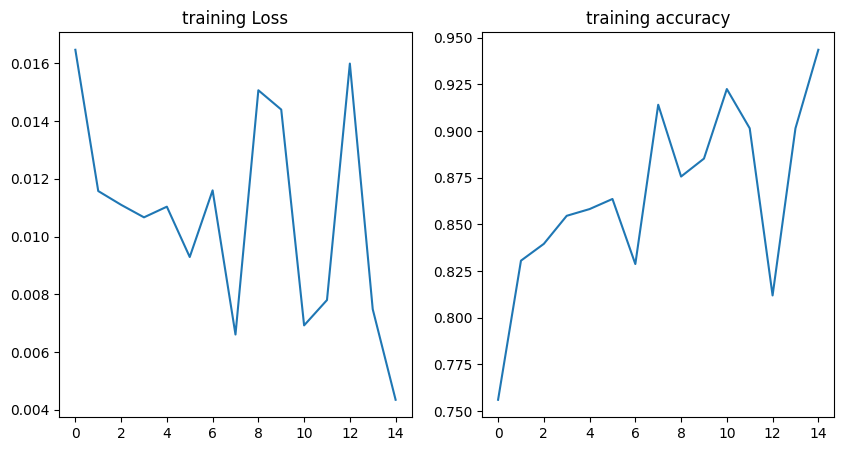

In [96]:
import matplotlib.pyplot as plt
fig , axes = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
axes[0].plot(losses)
axes[0].set_title('training Loss')
axes[1].plot(acc)
axes[1].set_title('training accuracy');

### testing FC

In [85]:
fc_model.eval()
epoch_correct = 0
for X,y in test_loader:
  X = X.to(device).float()
  y = y.to(device).float()
  y_hat = fc_model(X).squeeze(-1)
  loss = criterion(y_hat, y)
  epoch_loss += loss.item()
  predicted = (y_hat > 0.5).float()
  correct = (predicted == y).sum().item()
  epoch_correct+=correct
epoch_loss /= (len(test_loader)*test_loader.batch_size)
epoch_correct /= (len(test_loader)*test_loader.batch_size)
print(f'testing on test dataset : loss = {epoch_loss:.04f}  accuracy = {epoch_correct*100:.03f}%')

testing on test dataset : loss = 0.0298  accuracy = 85.817%


## C) LSTM

### data_loader

In [144]:
from sklearn.model_selection import train_test_split
# y = df['p_np'].values
# X = data_one_hot

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

class Smiles_sequential_dataSet(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    def __len__(self):
        return len(self.X)

train_set = Smiles_sequential_dataSet(X_train,y_train)
test_set = Smiles_sequential_dataSet(X_test,y_test)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [145]:
X_samlpe , y_sample = next(iter(train_loader))
X_samlpe.shape , y_sample.shape

(torch.Size([64, 73, 73]), torch.Size([64]))

### batch_lstm

I found this model on internet  and thought that maybe this would have better perforamce but the result was nearly the same so i used reqular LSTM

In [ ]:
"""Implementation of batch-normalized LSTM."""
import torch
from torch import nn
from torch.nn import functional, init

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


class SeparatedBatchNorm1d(nn.Module):
    """
    A batch normalization module which keeps its running mean
    and variance separately per timestep.
    """

    def __init__(self, num_features, max_length, eps=1e-5, momentum=0.1,
                 affine=True):
        """
        Most parts are copied from
        torch.nn.modules.batchnorm._BatchNorm.
        """

        super(SeparatedBatchNorm1d, self).__init__()
        self.num_features = num_features
        self.max_length = max_length
        self.affine = affine
        self.eps = eps
        self.momentum = momentum
        if self.affine:
            self.weight = nn.Parameter(torch.FloatTensor(num_features))
            self.bias = nn.Parameter(torch.FloatTensor(num_features))
        else:
            self.register_parameter('weight', None)
            self.register_parameter('bias', None)
        for i in range(max_length):
            self.register_buffer(
                'running_mean_{}'.format(i), torch.zeros(num_features))
            self.register_buffer(
                'running_var_{}'.format(i), torch.ones(num_features))
        self.reset_parameters()

    def reset_parameters(self):
        for i in range(self.max_length):
            running_mean_i = getattr(self, 'running_mean_{}'.format(i))
            running_var_i = getattr(self, 'running_var_{}'.format(i))
            running_mean_i.zero_()
            running_var_i.fill_(1)
        if self.affine:
            self.weight.data.uniform_()
            self.bias.data.zero_()

    def _check_input_dim(self, input_):
        if input_.size(1) != self.running_mean_0.nelement():
            raise ValueError('got {}-feature tensor, expected {}'
                             .format(input_.size(1), self.num_features))

    def forward(self, input_, time):
        self._check_input_dim(input_)
        if time >= self.max_length:
            time = self.max_length - 1
        running_mean = getattr(self, 'running_mean_{}'.format(time))
        running_var = getattr(self, 'running_var_{}'.format(time))
        return functional.batch_norm(
            input=input_, running_mean=running_mean, running_var=running_var,
            weight=self.weight, bias=self.bias, training=self.training,
            momentum=self.momentum, eps=self.eps)

    def __repr__(self):
        return ('{name}({num_features}, eps={eps}, momentum={momentum},'
                ' max_length={max_length}, affine={affine})'
                .format(name=self.__class__.__name__, **self.__dict__))


class LSTMCell(nn.Module):
    """A basic LSTM cell."""

    def __init__(self, input_size, hidden_size, use_bias=True):
        """
        Most parts are copied from torch.nn.LSTMCell.
        """

        super(LSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.use_bias = use_bias
        self.weight_ih = nn.Parameter(
            torch.FloatTensor(input_size, 4 * hidden_size))
        self.weight_hh = nn.Parameter(
            torch.FloatTensor(hidden_size, 4 * hidden_size))
        if use_bias:
            self.bias = nn.Parameter(torch.FloatTensor(4 * hidden_size))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        """
        Initialize parameters following the way proposed in the paper.
        """

        init.orthogonal_(self.weight_ih.data)
        weight_hh_data = torch.eye(self.hidden_size)
        weight_hh_data = weight_hh_data.repeat(1, 4)
        with torch.no_grad():
            self.weight_hh.set_(weight_hh_data)
        # The bias is just set to zero vectors.
        if self.use_bias:
            init.constant_(self.bias.data, val=0)

    def forward(self, input_, hx):
        """
        Args:
            input_: A (batch, input_size) tensor containing input
                features.
            hx: A tuple (h_0, c_0), which contains the initial hidden
                and cell state, where the size of both states is
                (batch, hidden_size).
        Returns:
            h_1, c_1: Tensors containing the next hidden and cell state.
        """

        h_0, c_0 = hx
        batch_size = h_0.size(0)
        bias_batch = (self.bias.unsqueeze(0)
                      .expand(batch_size, *self.bias.size()))
        wh_b = torch.addmm(bias_batch, h_0, self.weight_hh)
        wi = torch.mm(input_, self.weight_ih)
        f, i, o, g = torch.split(wh_b + wi, self.hidden_size, dim=1)
        c_1 = torch.sigmoid(f) * c_0 + torch.sigmoid(i) * torch.tanh(g)
        h_1 = torch.sigmoid(o) * torch.tanh(c_1)
        return h_1, c_1

    def __repr__(self):
        s = '{name}({input_size}, {hidden_size})'
        return s.format(name=self.__class__.__name__, **self.__dict__)


class BNLSTMCell(nn.Module):
    """A BN-LSTM cell."""

    def __init__(self, input_size, hidden_size, max_length, use_bias=True):

        super(BNLSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.max_length = max_length
        self.use_bias = use_bias
        self.weight_ih = nn.Parameter(
            torch.FloatTensor(input_size, 4 * hidden_size))
        self.weight_hh = nn.Parameter(
            torch.FloatTensor(hidden_size, 4 * hidden_size))
        if use_bias:
            self.bias = nn.Parameter(torch.FloatTensor(4 * hidden_size))
        else:
            self.register_parameter('bias', None)
        # BN parameters
        self.bn_ih = SeparatedBatchNorm1d(
            num_features=4 * hidden_size, max_length=max_length)
        self.bn_hh = SeparatedBatchNorm1d(
            num_features=4 * hidden_size, max_length=max_length)
        self.bn_c = SeparatedBatchNorm1d(
            num_features=hidden_size, max_length=max_length)
        self.reset_parameters()

    def reset_parameters(self):
        """
        Initialize parameters following the way proposed in the paper.
        """

        # The input-to-hidden weight matrix is initialized orthogonally.
        init.orthogonal_(self.weight_ih.data)
        # The hidden-to-hidden weight matrix is initialized as an identity
        # matrix.
        weight_hh_data = torch.eye(self.hidden_size)
        weight_hh_data = weight_hh_data.repeat(1, 4)
        with torch.no_grad():
            self.weight_hh.set_(weight_hh_data)
        # The bias is just set to zero vectors.
        init.constant_(self.bias.data, val=0)
        # Initialization of BN parameters.
        self.bn_ih.reset_parameters()
        self.bn_hh.reset_parameters()
        self.bn_c.reset_parameters()
        self.bn_ih.bias.data.fill_(0)
        self.bn_hh.bias.data.fill_(0)
        self.bn_ih.weight.data.fill_(0.1)
        self.bn_hh.weight.data.fill_(0.1)
        self.bn_c.weight.data.fill_(0.1)

    def forward(self, input_, hx, time):
        """
        Args:
            input_: A (batch, input_size) tensor containing input
                features.
            hx: A tuple (h_0, c_0), which contains the initial hidden
                and cell state, where the size of both states is
                (batch, hidden_size).
            time: The current timestep value, which is used to
                get appropriate running statistics.
        Returns:
            h_1, c_1: Tensors containing the next hidden and cell state.
        """

        h_0, c_0 = hx
        batch_size = h_0.size(0)
        bias_batch = (self.bias.unsqueeze(0)
                      .expand(batch_size, *self.bias.size()))
        wh = torch.mm(h_0, self.weight_hh)
        wi = torch.mm(input_, self.weight_ih)
        bn_wh = self.bn_hh(wh, time=time)
        bn_wi = self.bn_ih(wi, time=time)
        f, i, o, g = torch.split(bn_wh + bn_wi + bias_batch, self.hidden_size, dim=1)
        c_1 = torch.sigmoid(f) * c_0 + torch.sigmoid(i) * torch.tanh(g)
        h_1 = torch.sigmoid(o) * torch.tanh(self.bn_c(c_1, time=time))
        return h_1, c_1


class LSTM(nn.Module):
    """A module that runs multiple steps of LSTM."""

    def __init__(self, cell_class, input_size, hidden_size, num_layers=1,
                 use_bias=True, batch_first=False, dropout=0, **kwargs):
        super(LSTM, self).__init__()
        self.cell_class = cell_class
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.use_bias = use_bias
        self.batch_first = batch_first
        self.dropout = dropout

        for layer in range(num_layers):
            layer_input_size = input_size if layer == 0 else hidden_size
            cell = cell_class(input_size=layer_input_size,
                              hidden_size=hidden_size,
                              **kwargs)
            setattr(self, 'cell_{}'.format(layer), cell)
        self.dropout_layer = nn.Dropout(dropout)
        self.reset_parameters()

    def get_cell(self, layer):
        return getattr(self, 'cell_{}'.format(layer))

    def reset_parameters(self):
        for layer in range(self.num_layers):
            cell = self.get_cell(layer)
            cell.reset_parameters()

    @staticmethod
    def _forward_rnn(cell, input_, length, hx):
        max_time = input_.size(0)
        output = []
        for time in range(max_time):
            if isinstance(cell, BNLSTMCell):
                h_next, c_next = cell(input_=input_[time], hx=hx, time=time)
            else:
                h_next, c_next = cell(input_=input_[time], hx=hx)
            mask = (time < length).float().unsqueeze(1).expand_as(h_next).to(device)
            h_next = (h_next * mask + hx[0] * (1 - mask)).to(device)
            c_next = (c_next * mask + hx[1] * (1 - mask)).to(device)
            hx_next = (h_next, c_next)
            output.append(h_next)
            hx = hx_next
        output = torch.stack(output, 0)
        return output, hx

    def forward(self, input_, length=None, hx=None):
        if self.batch_first:
            input_ = input_.transpose(0, 1)
        max_time, batch_size, _ = input_.size()
        if length is None:
            length = torch.LongTensor([max_time] * batch_size)
            # if input_.is_cuda:
            #     device = input_.get_device()
            #     length = length.cuda(device)
        if hx is None:
            hx = input_.data.new(batch_size, self.hidden_size).zero_()
            hx = (hx, hx)
        h_n = []
        c_n = []
        layer_output = None
        for layer in range(self.num_layers):
            cell = self.get_cell(layer)
            layer_output, (layer_h_n, layer_c_n) = LSTM._forward_rnn(
                cell=cell, input_=input_, length=length, hx=hx)
            input_ = self.dropout_layer(layer_output)
            h_n.append(layer_h_n)
            c_n.append(layer_c_n)
        output = layer_output
        h_n = torch.stack(h_n, 0)
        c_n = torch.stack(c_n, 0)
        return output, (h_n, c_n)


### reqular LSTM

In [146]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import cross_val_score

# Define the LSTM model
class LSTM_binaryClassifier(nn.Module):
    def __init__(self, input_size, hidden_size,num_layers,bid):
        self.bid = bid
        self.num_layers = num_layers
        super(LSTM_binaryClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,batch_first=True,num_layers=num_layers,dropout=0.5,bidirectional=bid)
        if bid :
          self.fc1 = nn.Linear(hidden_size * 2, 1)
        else :
          self.fc1 = nn.Linear(hidden_size, 1)
        # self.fc2 = nn.Linear(hidden_size//2, 1)
        self.dropout = nn.Dropout(0.5)
        self.sigmoid = nn.Sigmoid()
        self.ReLU = nn.ReLU()

    def forward(self, x):
        # h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        # c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        lstm_out, _ = self.lstm(x)
        # print(lstm_out.shape)
        # lstm_out = self.dropout(lstm_out[:, -1, :])  # Use the output from the last time step
        # lstm_out = lstm_out[:, -1, :].reshape(lstm_out.shape[0], -1)
        # print('hi')
        # print(lstm_out.shape)
        # lstm_out = lstm_out.transpose(0,1)
        if self.bid :
          lstm_out = torch.cat((lstm_out[:, -1, :self.hidden_size], lstm_out[:, 0, self.hidden_size:]), dim=1)
        else:
          lstm_out = lstm_out[:, -1, :].reshape(lstm_out.shape[0], -1)
        # print(lstm_out.shape)
        output = self.fc1(lstm_out)
        # print(output.shape)
        # output = self.ReLU(output)
        # print('2')
        # output = self.fc2(output)
        # print('3')
        output = self.sigmoid(output)
        return output

input_size = 73
hidden_size = 16
num_layers = 2
LSTM_model = LSTM_binaryClassifier(input_size, hidden_size, num_layers,bid=False).to(device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [147]:
X_samlpe.shape

torch.Size([64, 73, 73])

In [148]:
LSTM_model(X_samlpe.to(device).float()).shape

torch.Size([64, 1])

In [149]:
from tqdm.notebook import tqdm
losses = []
acc = []
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(LSTM_model.parameters(), lr=0.001)
n_epochs = 80
for epoch in tqdm(range(n_epochs)):
  LSTM_model.train()
  epoch_loss = 0
  epoch_correct = 0
  for X,y in train_loader:
    X = X.to(device).float()
    y = y.to(device).float()
    y_hat = LSTM_model(X).squeeze(-1)
    # print(X.shape)
    loss = criterion(y_hat, y)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
    predicted = (y_hat > 0.5).float()
    # print(predicted)
    # print(y)
    correct = (predicted == y).sum().item()
    epoch_correct+=correct
  epoch_loss /= (len(train_loader)*train_loader.batch_size)
  epoch_correct /= (len(train_loader)*train_loader.batch_size)
  losses.append(epoch_loss)
  acc.append(epoch_correct)
  print(f'epoch {epoch+1} : loss = {epoch_loss:0.04f}  accuracy = {epoch_correct*100:.03f}%')

  0%|          | 0/80 [00:00<?, ?it/s]

epoch 1 : loss = 0.0099  accuracy = 75.240%
epoch 2 : loss = 0.0090  accuracy = 75.240%
epoch 3 : loss = 0.0086  accuracy = 75.240%
epoch 4 : loss = 0.0090  accuracy = 75.240%
epoch 5 : loss = 0.0085  accuracy = 75.240%
epoch 6 : loss = 0.0085  accuracy = 75.240%
epoch 7 : loss = 0.0087  accuracy = 75.240%
epoch 8 : loss = 0.0087  accuracy = 75.240%
epoch 9 : loss = 0.0085  accuracy = 75.240%
epoch 10 : loss = 0.0084  accuracy = 75.240%
epoch 11 : loss = 0.0083  accuracy = 75.240%
epoch 12 : loss = 0.0084  accuracy = 75.240%
epoch 13 : loss = 0.0084  accuracy = 76.262%
epoch 14 : loss = 0.0084  accuracy = 76.623%
epoch 15 : loss = 0.0083  accuracy = 76.442%
epoch 16 : loss = 0.0083  accuracy = 76.322%
epoch 17 : loss = 0.0083  accuracy = 76.022%
epoch 18 : loss = 0.0082  accuracy = 76.502%
epoch 19 : loss = 0.0083  accuracy = 73.978%
epoch 20 : loss = 0.0082  accuracy = 74.880%
epoch 21 : loss = 0.0082  accuracy = 75.240%
epoch 22 : loss = 0.0082  accuracy = 75.240%
epoch 23 : loss = 0

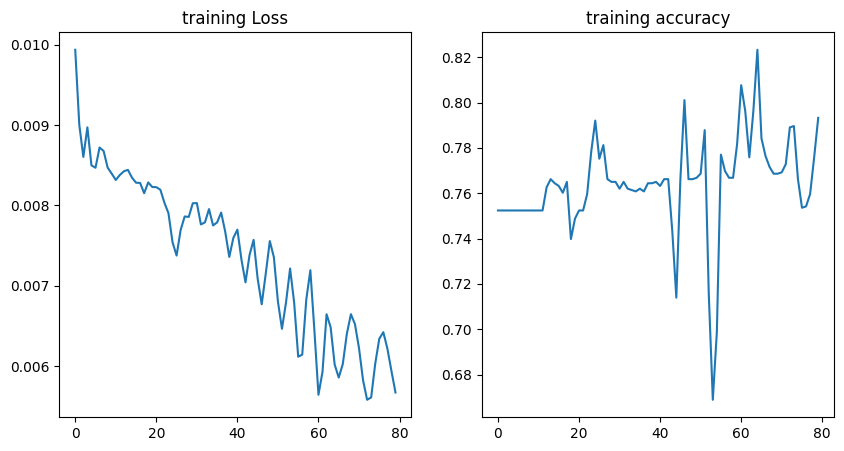

In [150]:
import matplotlib.pyplot as plt
fig , axes = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
axes[0].plot(losses)
axes[0].set_title('training Loss')
axes[1].plot(acc)
axes[1].set_title('training accuracy');

another run

In [168]:
from tqdm.notebook import tqdm
losses = []
acc = []
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(LSTM_model.parameters(), lr=0.001)
n_epochs = 80
for epoch in tqdm(range(n_epochs)):
  LSTM_model.train()
  epoch_loss = 0
  epoch_correct = 0
  for X,y in train_loader:
    X = X.to(device).float()
    y = y.to(device).float()
    y_hat = LSTM_model(X).squeeze(-1)
    # print(X.shape)
    loss = criterion(y_hat, y)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
    predicted = (y_hat > 0.5).float()
    # print(predicted)
    # print(y)
    correct = (predicted == y).sum().item()
    epoch_correct+=correct
  epoch_loss /= (len(train_loader)*train_loader.batch_size)
  epoch_correct /= (len(train_loader)*train_loader.batch_size)
  losses.append(epoch_loss)
  acc.append(epoch_correct)
  print(f'epoch {epoch+1} : loss = {epoch_loss:0.04f}  accuracy = {epoch_correct*100:.03f}%')

  0%|          | 0/80 [00:00<?, ?it/s]

epoch 1 : loss = 0.0057  accuracy = 77.103%
epoch 2 : loss = 0.0057  accuracy = 77.344%
epoch 3 : loss = 0.0057  accuracy = 77.464%
epoch 4 : loss = 0.0057  accuracy = 78.245%
epoch 5 : loss = 0.0057  accuracy = 78.546%
epoch 6 : loss = 0.0056  accuracy = 78.606%
epoch 7 : loss = 0.0056  accuracy = 78.606%
epoch 8 : loss = 0.0056  accuracy = 78.666%
epoch 9 : loss = 0.0056  accuracy = 78.666%
epoch 10 : loss = 0.0055  accuracy = 78.005%
epoch 11 : loss = 0.0054  accuracy = 76.202%
epoch 12 : loss = 0.0055  accuracy = 76.202%
epoch 13 : loss = 0.0054  accuracy = 76.142%
epoch 14 : loss = 0.0054  accuracy = 76.442%
epoch 15 : loss = 0.0054  accuracy = 76.382%
epoch 16 : loss = 0.0054  accuracy = 76.502%
epoch 17 : loss = 0.0053  accuracy = 76.803%
epoch 18 : loss = 0.0053  accuracy = 77.224%
epoch 19 : loss = 0.0053  accuracy = 77.224%
epoch 20 : loss = 0.0053  accuracy = 77.464%
epoch 21 : loss = 0.0053  accuracy = 77.644%
epoch 22 : loss = 0.0053  accuracy = 79.087%
epoch 23 : loss = 0

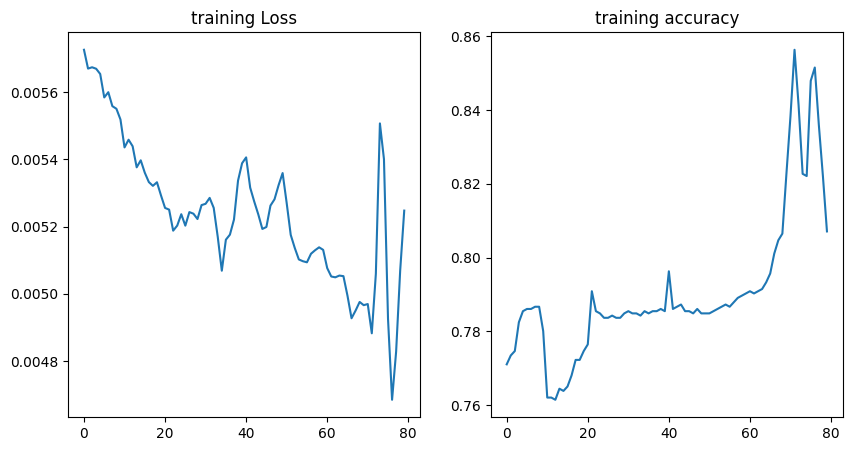

In [169]:
import matplotlib.pyplot as plt
fig , axes = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
axes[0].plot(losses)
axes[0].set_title('training Loss')
axes[1].plot(acc)
axes[1].set_title('training accuracy');

In [170]:
LSTM_model.eval()
epoch_correct = 0
for X,y in test_loader:
  X = X.to(device).float()
  y = y.to(device).float()
  y_hat = LSTM_model(X).squeeze(-1)
  loss = criterion(y_hat, y)
  epoch_loss += loss.item()
  predicted = (y_hat > 0.5).float()
  correct = (predicted == y).sum().item()
  epoch_correct+=correct
epoch_loss /= (len(test_loader)*test_loader.batch_size)
epoch_correct /= (len(test_loader)*test_loader.batch_size)
print(f'testing on test dataset : loss = {epoch_loss:.04f}  accuracy = {epoch_correct*100:.03f}%')

testing on test dataset : loss = 0.0065  accuracy = 74.777%


## D) bidirac LSTM

In [152]:
LSTM_model_bidirec = LSTM_binaryClassifier(input_size, hidden_size, num_layers,bid=True).to(device)

### training

In [153]:
from tqdm.notebook import tqdm
losses = []
acc = []
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(LSTM_model_bidirec.parameters(), lr=0.001)
n_epochs = 80
for epoch in tqdm(range(n_epochs)):
  LSTM_model_bidirec.train()
  epoch_loss = 0
  epoch_correct = 0
  for X,y in train_loader:
    X = X.to(device).float()
    y = y.to(device).float()
    y_hat = LSTM_model_bidirec(X).squeeze(-1)
    # print(X.shape)
    loss = criterion(y_hat, y)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
    predicted = (y_hat > 0.5).float()
    # print(predicted)
    # print(y)
    correct = (predicted == y).sum().item()
    epoch_correct+=correct
  epoch_loss /= (len(train_loader)*train_loader.batch_size)
  epoch_correct /= (len(train_loader)*train_loader.batch_size)
  losses.append(epoch_loss)
  acc.append(epoch_correct)
  print(f'epoch {epoch+1} : loss = {epoch_loss:0.04f}  accuracy = {epoch_correct*100:.03f}%')

  0%|          | 0/80 [00:00<?, ?it/s]

epoch 1 : loss = 0.0097  accuracy = 75.240%
epoch 2 : loss = 0.0088  accuracy = 75.240%
epoch 3 : loss = 0.0087  accuracy = 75.240%
epoch 4 : loss = 0.0086  accuracy = 75.240%
epoch 5 : loss = 0.0083  accuracy = 75.240%
epoch 6 : loss = 0.0085  accuracy = 75.240%
epoch 7 : loss = 0.0085  accuracy = 75.240%
epoch 8 : loss = 0.0082  accuracy = 75.240%
epoch 9 : loss = 0.0080  accuracy = 75.240%
epoch 10 : loss = 0.0080  accuracy = 75.481%
epoch 11 : loss = 0.0079  accuracy = 77.103%
epoch 12 : loss = 0.0076  accuracy = 79.627%
epoch 13 : loss = 0.0071  accuracy = 78.606%
epoch 14 : loss = 0.0067  accuracy = 78.305%
epoch 15 : loss = 0.0062  accuracy = 78.606%
epoch 16 : loss = 0.0066  accuracy = 76.983%
epoch 17 : loss = 0.0063  accuracy = 76.202%
epoch 18 : loss = 0.0066  accuracy = 74.279%
epoch 19 : loss = 0.0057  accuracy = 79.748%
epoch 20 : loss = 0.0059  accuracy = 78.005%
epoch 21 : loss = 0.0061  accuracy = 77.464%
epoch 22 : loss = 0.0057  accuracy = 79.087%
epoch 23 : loss = 0

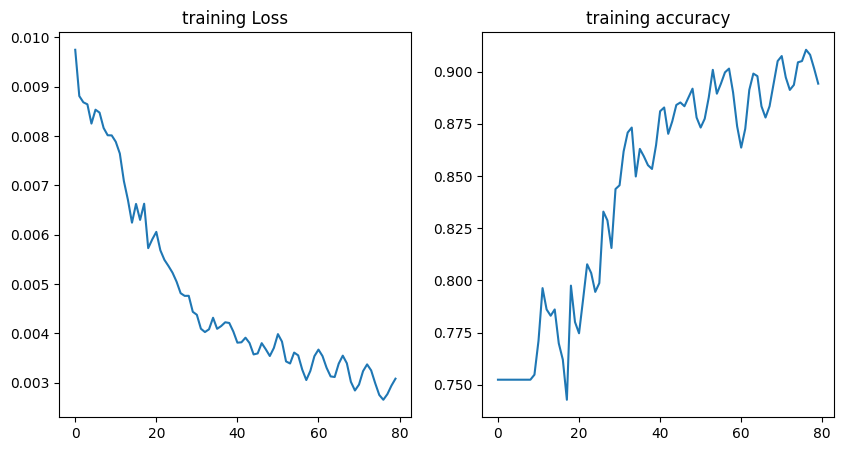

In [154]:
import matplotlib.pyplot as plt
fig , axes = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
axes[0].plot(losses)
axes[0].set_title('training Loss')
axes[1].plot(acc)
axes[1].set_title('training accuracy');

In [155]:
LSTM_model_bidirec.eval()
epoch_correct = 0
for X,y in test_loader:
  X = X.to(device).float()
  y = y.to(device).float()
  y_hat = LSTM_model_bidirec(X).squeeze(-1)
  loss = criterion(y_hat, y)
  epoch_loss += loss.item()
  predicted = (y_hat > 0.5).float()
  correct = (predicted == y).sum().item()
  epoch_correct+=correct
epoch_loss /= (len(test_loader)*test_loader.batch_size)
epoch_correct /= (len(test_loader)*test_loader.batch_size)
print(f'testing on test dataset : loss = {epoch_loss:.04f}  accuracy = {epoch_correct*100:.03f}%')

testing on test dataset : loss = 0.0050  accuracy = 81.250%


here is another run

In [107]:
from tqdm.notebook import tqdm
losses = []
acc = []
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(LSTM_model_bidirec.parameters(), lr=0.001)
n_epochs = 80
for epoch in tqdm(range(n_epochs)):
  LSTM_model_bidirec.train()
  epoch_loss = 0
  epoch_correct = 0
  for X,y in train_loader:
    X = X.to(device).float()
    y = y.to(device).float()
    y_hat = LSTM_model_bidirec(X).squeeze(-1)
    # print(X.shape)
    loss = criterion(y_hat, y)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
    predicted = (y_hat > 0.5).float()
    # print(predicted)
    # print(y)
    correct = (predicted == y).sum().item()
    epoch_correct+=correct
  epoch_loss /= (len(train_loader)*train_loader.batch_size)
  epoch_correct /= (len(train_loader)*train_loader.batch_size)
  losses.append(epoch_loss)
  acc.append(epoch_correct)
  print(f'epoch {epoch+1} : loss = {epoch_loss:0.04f}  accuracy = {epoch_correct*100:.03f}%')

  0%|          | 0/80 [00:00<?, ?it/s]

epoch 1 : loss = 0.0099  accuracy = 75.240%
epoch 2 : loss = 0.0088  accuracy = 75.240%
epoch 3 : loss = 0.0088  accuracy = 75.240%
epoch 4 : loss = 0.0087  accuracy = 75.240%
epoch 5 : loss = 0.0084  accuracy = 75.240%
epoch 6 : loss = 0.0086  accuracy = 75.240%
epoch 7 : loss = 0.0085  accuracy = 75.240%
epoch 8 : loss = 0.0081  accuracy = 75.240%
epoch 9 : loss = 0.0080  accuracy = 75.240%
epoch 10 : loss = 0.0080  accuracy = 75.240%
epoch 11 : loss = 0.0078  accuracy = 75.481%
epoch 12 : loss = 0.0073  accuracy = 78.065%
epoch 13 : loss = 0.0070  accuracy = 78.365%
epoch 14 : loss = 0.0065  accuracy = 78.846%
epoch 15 : loss = 0.0062  accuracy = 80.589%
epoch 16 : loss = 0.0058  accuracy = 81.490%
epoch 17 : loss = 0.0056  accuracy = 80.409%
epoch 18 : loss = 0.0057  accuracy = 80.950%
epoch 19 : loss = 0.0054  accuracy = 81.611%
epoch 20 : loss = 0.0049  accuracy = 83.594%
epoch 21 : loss = 0.0049  accuracy = 82.212%
epoch 22 : loss = 0.0048  accuracy = 81.310%
epoch 23 : loss = 0

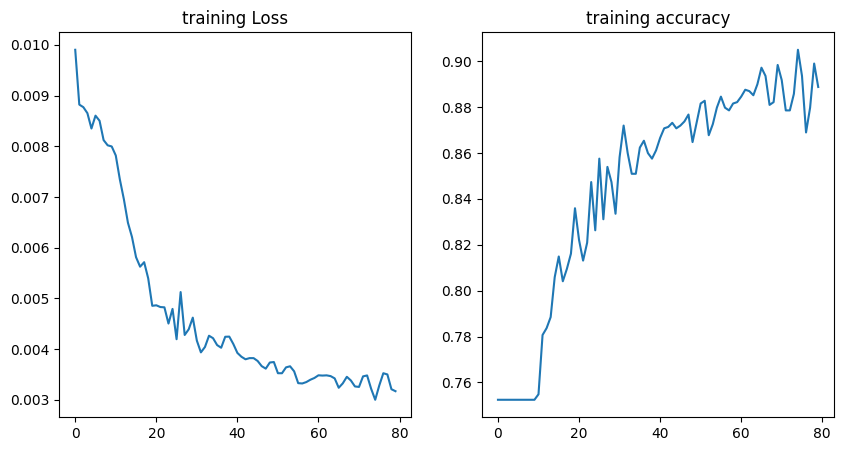

In [108]:
import matplotlib.pyplot as plt
fig , axes = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
axes[0].plot(losses)
axes[0].set_title('training Loss')
axes[1].plot(acc)
axes[1].set_title('training accuracy');

### testing

In [109]:
LSTM_model_bidirec.eval()
epoch_correct = 0
for X,y in test_loader:
  X = X.to(device).float()
  y = y.to(device).float()
  y_hat = LSTM_model_bidirec(X).squeeze(-1)
  loss = criterion(y_hat, y)
  epoch_loss += loss.item()
  predicted = (y_hat > 0.5).float()
  correct = (predicted == y).sum().item()
  epoch_correct+=correct
epoch_loss /= (len(test_loader)*test_loader.batch_size)
epoch_correct /= (len(test_loader)*test_loader.batch_size)
print(f'testing on test dataset : loss = {epoch_loss:.04f}  accuracy = {epoch_correct*100:.03f}%')

testing on test dataset : loss = 0.0051  accuracy = 80.804%


## E) Kfold validation

In [142]:
from sklearn.model_selection import KFold
from copy import deepcopy
from tqdm import tqdm
def kfold_val_fc(dataset,k,num_epochs=15):
  results = {}
  kfold = KFold(n_splits=k, shuffle=True)
  print('--------------------------------')
  # K-fold Cross Validation model evaluation
  for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):

    # Print
    print(f'FOLD {fold}')
    print('--------------------------------')

    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)

    # Define data loaders for training and testing data in this fold
    trainloader = torch.utils.data.DataLoader(
                      dataset,
                      batch_size=10, sampler=train_subsampler)
    testloader = torch.utils.data.DataLoader(
                      dataset,
                      batch_size=10, sampler=test_subsampler)

    # Init the neural network
    network = nn.Sequential(
    nn.Linear(X_samlpe.shape[1], 1),
    nn.Sigmoid()
    ).to(device)
    # Initialize optimizer
    optimizer = torch.optim.Adam(network.parameters(), lr=0.001)


    # Run the training loop for defined number of epochs
    losses = []
    acc = []
    criterion = nn.BCELoss()
    for epoch in tqdm(range(num_epochs)):
      network.train()
      epoch_loss = 0
      epoch_correct = 0
      for X,y in train_loader:
        X = X.to(device).float()
        y = y.to(device).float()
        y_hat = network(X).squeeze(-1)
        # print(X.shape)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        predicted = (y_hat > 0.5).float()
        # print(predicted)
        # print(y)
        correct = (predicted == y).sum().item()
        epoch_correct+=correct
      epoch_loss /= (len(train_loader)*train_loader.batch_size)
      epoch_correct /= (len(train_loader)*train_loader.batch_size)
      losses.append(epoch_loss)
      acc.append(epoch_correct)
      if epoch+1 % 10 == 0:
        print(f'epoch {epoch+1} : loss = {epoch_loss:0.04f}  accuracy = {epoch_correct*100:.03f}%')

    # Process is complete.
    print('Training process has finished. Saving trained model.')

    # Print about testing
    print('Starting testing')

    # Saving the model
    save_path = f'./model-fold-{fold}.pth'
    torch.save(network.state_dict(), save_path)

    # Evaluationfor this fold
    correct, total = 0, 0
    network.eval()
    epoch_correct = 0
    for X,y in test_loader:
      X = X.to(device).float()
      y = y.to(device).float()
      y_hat = network(X).squeeze(-1)
      loss = criterion(y_hat, y)
      epoch_loss += loss.item()
      predicted = (y_hat > 0.5).float()
      correct = (predicted == y).sum().item()
      epoch_correct+=correct
    epoch_loss /= (len(test_loader)*test_loader.batch_size)
    epoch_correct /= (len(test_loader)*test_loader.batch_size)
    print(f'testing on test dataset : loss = {epoch_loss:.04f}  accuracy = {epoch_correct*100:.03f}%')
    # Print accuracy
    print('Accuracy for fold %d: %d %%' % (fold, 100.0 * epoch_correct))
    print('--------------------------------')
    results[fold] = 100.0 * (epoch_correct)

  # Print fold results
  print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k} FOLDS')
  print('--------------------------------')
  sum = 0.0
  vals = []
  for key, value in results.items():
    print(f'Fold {key}: {value} %')
    sum += value
    vals.append(value)
  print(f'Average: {sum/len(results.items())} %')
  print(f'STD: {np.std(vals)}')
dataset =  ConcatDataset([train_set, test_set])
# LSTM_model_fold = LSTM_binaryClassifier(input_size, hidden_size, num_layers,bid=False).to(device)

In [143]:
kfold_val_fc(dataset,10)

--------------------------------
FOLD 0
--------------------------------


100%|██████████| 15/15 [00:02<00:00,  7.05it/s]


Training process has finished. Saving trained model.
Starting testing
testing on test dataset : loss = 0.0198  accuracy = 83.413%
Accuracy for fold 0: 83 %
--------------------------------
FOLD 1
--------------------------------


100%|██████████| 15/15 [00:01<00:00,  9.54it/s]


Training process has finished. Saving trained model.
Starting testing
testing on test dataset : loss = 0.0247  accuracy = 86.298%
Accuracy for fold 1: 86 %
--------------------------------
FOLD 2
--------------------------------


100%|██████████| 15/15 [00:01<00:00,  9.73it/s]


Training process has finished. Saving trained model.
Starting testing
testing on test dataset : loss = 0.0212  accuracy = 86.298%
Accuracy for fold 2: 86 %
--------------------------------
FOLD 3
--------------------------------


100%|██████████| 15/15 [00:01<00:00,  9.83it/s]


Training process has finished. Saving trained model.
Starting testing
testing on test dataset : loss = 0.0281  accuracy = 85.577%
Accuracy for fold 3: 85 %
--------------------------------
FOLD 4
--------------------------------


100%|██████████| 15/15 [00:01<00:00,  9.68it/s]


Training process has finished. Saving trained model.
Starting testing
testing on test dataset : loss = 0.0191  accuracy = 86.538%
Accuracy for fold 4: 86 %
--------------------------------
FOLD 5
--------------------------------


100%|██████████| 15/15 [00:01<00:00,  9.85it/s]


Training process has finished. Saving trained model.
Starting testing
testing on test dataset : loss = 0.0206  accuracy = 86.779%
Accuracy for fold 5: 86 %
--------------------------------
FOLD 6
--------------------------------


100%|██████████| 15/15 [00:01<00:00,  8.66it/s]


Training process has finished. Saving trained model.
Starting testing
testing on test dataset : loss = 0.0189  accuracy = 86.538%
Accuracy for fold 6: 86 %
--------------------------------
FOLD 7
--------------------------------


100%|██████████| 15/15 [00:01<00:00,  8.34it/s]


Training process has finished. Saving trained model.
Starting testing
testing on test dataset : loss = 0.0216  accuracy = 87.019%
Accuracy for fold 7: 87 %
--------------------------------
FOLD 8
--------------------------------


100%|██████████| 15/15 [00:01<00:00,  8.92it/s]


Training process has finished. Saving trained model.
Starting testing
testing on test dataset : loss = 0.0177  accuracy = 85.337%
Accuracy for fold 8: 85 %
--------------------------------
FOLD 9
--------------------------------


100%|██████████| 15/15 [00:01<00:00,  9.83it/s]

Training process has finished. Saving trained model.
Starting testing
testing on test dataset : loss = 0.0205  accuracy = 86.538%
Accuracy for fold 9: 86 %
--------------------------------
K-FOLD CROSS VALIDATION RESULTS FOR 10 FOLDS
--------------------------------
Fold 0: 83.41346153846155 %
Fold 1: 86.29807692307693 %
Fold 2: 86.29807692307693 %
Fold 3: 85.57692307692307 %
Fold 4: 86.53846153846155 %
Fold 5: 86.77884615384616 %
Fold 6: 86.53846153846155 %
Fold 7: 87.01923076923077 %
Fold 8: 85.33653846153845 %
Fold 9: 86.53846153846155 %
Average: 86.03365384615385 %
STD: 0.9995491772255685


In [136]:
from sklearn.model_selection import KFold
from copy import deepcopy
from tqdm import tqdm
def kfold_val(bid,dataset,k,num_epochs=80):
  results = {}
  kfold = KFold(n_splits=k, shuffle=True)
  print('--------------------------------')
  # K-fold Cross Validation model evaluation
  for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):

    # Print
    print(f'FOLD {fold}')
    print('--------------------------------')

    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)

    # Define data loaders for training and testing data in this fold
    trainloader = torch.utils.data.DataLoader(
                      dataset,
                      batch_size=10, sampler=train_subsampler)
    testloader = torch.utils.data.DataLoader(
                      dataset,
                      batch_size=10, sampler=test_subsampler)

    # Init the neural network
    network = LSTM_binaryClassifier(input_size, hidden_size, num_layers,bid=bid).to(device)
    # Initialize optimizer
    optimizer = torch.optim.Adam(network.parameters(), lr=0.001)


    # Run the training loop for defined number of epochs
    losses = []
    acc = []
    criterion = nn.BCELoss()
    for epoch in tqdm(range(num_epochs)):
      network.train()
      epoch_loss = 0
      epoch_correct = 0
      for X,y in train_loader:
        X = X.to(device).float()
        y = y.to(device).float()
        y_hat = network(X).squeeze(-1)
        # print(X.shape)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        predicted = (y_hat > 0.5).float()
        # print(predicted)
        # print(y)
        correct = (predicted == y).sum().item()
        epoch_correct+=correct
      epoch_loss /= (len(train_loader)*train_loader.batch_size)
      epoch_correct /= (len(train_loader)*train_loader.batch_size)
      losses.append(epoch_loss)
      acc.append(epoch_correct)
      if epoch+1 % 10 == 0:
        print(f'epoch {epoch+1} : loss = {epoch_loss:0.04f}  accuracy = {epoch_correct*100:.03f}%')

    # Process is complete.
    print('Training process has finished. Saving trained model.')

    # Print about testing
    print('Starting testing')

    # Saving the model
    save_path = f'./model-fold-{fold}.pth'
    torch.save(network.state_dict(), save_path)

    # Evaluationfor this fold
    correct, total = 0, 0
    network.eval()
    epoch_correct = 0
    for X,y in test_loader:
      X = X.to(device).float()
      y = y.to(device).float()
      y_hat = network(X).squeeze(-1)
      loss = criterion(y_hat, y)
      epoch_loss += loss.item()
      predicted = (y_hat > 0.5).float()
      correct = (predicted == y).sum().item()
      epoch_correct+=correct
    epoch_loss /= (len(test_loader)*test_loader.batch_size)
    epoch_correct /= (len(test_loader)*test_loader.batch_size)
    print(f'testing on test dataset : loss = {epoch_loss:.04f}  accuracy = {epoch_correct*100:.03f}%')
    # Print accuracy
    print('Accuracy for fold %d: %d %%' % (fold, 100.0 * epoch_correct))
    print('--------------------------------')
    results[fold] = 100.0 * (epoch_correct)

  # Print fold results
  print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k} FOLDS')
  print('--------------------------------')
  sum = 0.0
  vals = []
  for key, value in results.items():
    print(f'Fold {key}: {value} %')
    sum += value
    vals.append(value)
  print(f'Average: {sum/len(results.items())} %')
  print(f'STD: {np.std(vals)}')
dataset =  ConcatDataset([train_set, test_set])
# LSTM_model_fold = LSTM_binaryClassifier(input_size, hidden_size, num_layers,bid=False).to(device)

### kfold for regular LSTM

In [137]:
kfold_val(False,dataset,10)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


--------------------------------
FOLD 0
--------------------------------


100%|██████████| 80/80 [00:08<00:00,  9.22it/s]


Training process has finished. Saving trained model.
Starting testing
testing on test dataset : loss = 0.0086  accuracy = 70.312%
Accuracy for fold 0: 70 %
--------------------------------
FOLD 1
--------------------------------


100%|██████████| 80/80 [00:07<00:00, 10.16it/s]


Training process has finished. Saving trained model.
Starting testing
testing on test dataset : loss = 0.0082  accuracy = 71.429%
Accuracy for fold 1: 71 %
--------------------------------
FOLD 2
--------------------------------


100%|██████████| 80/80 [00:08<00:00,  9.55it/s]


Training process has finished. Saving trained model.
Starting testing
testing on test dataset : loss = 0.0079  accuracy = 71.429%
Accuracy for fold 2: 71 %
--------------------------------
FOLD 3
--------------------------------


100%|██████████| 80/80 [00:07<00:00, 10.75it/s]


Training process has finished. Saving trained model.
Starting testing
testing on test dataset : loss = 0.0070  accuracy = 75.446%
Accuracy for fold 3: 75 %
--------------------------------
FOLD 4
--------------------------------


100%|██████████| 80/80 [00:08<00:00,  9.40it/s]


Training process has finished. Saving trained model.
Starting testing
testing on test dataset : loss = 0.0083  accuracy = 70.759%
Accuracy for fold 4: 70 %
--------------------------------
FOLD 5
--------------------------------


100%|██████████| 80/80 [00:07<00:00, 10.71it/s]


Training process has finished. Saving trained model.
Starting testing
testing on test dataset : loss = 0.0090  accuracy = 70.982%
Accuracy for fold 5: 70 %
--------------------------------
FOLD 6
--------------------------------


100%|██████████| 80/80 [00:08<00:00,  9.53it/s]


Training process has finished. Saving trained model.
Starting testing
testing on test dataset : loss = 0.0083  accuracy = 70.982%
Accuracy for fold 6: 70 %
--------------------------------
FOLD 7
--------------------------------


100%|██████████| 80/80 [00:07<00:00, 10.44it/s]


Training process has finished. Saving trained model.
Starting testing
testing on test dataset : loss = 0.0067  accuracy = 68.750%
Accuracy for fold 7: 68 %
--------------------------------
FOLD 8
--------------------------------


100%|██████████| 80/80 [00:08<00:00,  9.64it/s]


Training process has finished. Saving trained model.
Starting testing
testing on test dataset : loss = 0.0080  accuracy = 72.321%
Accuracy for fold 8: 72 %
--------------------------------
FOLD 9
--------------------------------


100%|██████████| 80/80 [00:08<00:00,  9.92it/s]

Training process has finished. Saving trained model.
Starting testing
testing on test dataset : loss = 0.0079  accuracy = 72.098%
Accuracy for fold 9: 72 %
--------------------------------
K-FOLD CROSS VALIDATION RESULTS FOR 10 FOLDS
--------------------------------
Fold 0: 70.3125 %
Fold 1: 71.42857142857143 %
Fold 2: 71.42857142857143 %
Fold 3: 75.44642857142857 %
Fold 4: 70.75892857142857 %
Fold 5: 70.98214285714286 %
Fold 6: 70.98214285714286 %
Fold 7: 68.75 %
Fold 8: 72.32142857142857 %
Fold 9: 72.09821428571429 %
Average: 71.45089285714286 %
STD: 1.6325191520737983


### kfold for  LSTM

In [138]:
kfold_val(True,dataset,10)

--------------------------------
FOLD 0
--------------------------------


100%|██████████| 80/80 [00:09<00:00,  8.77it/s]


Training process has finished. Saving trained model.
Starting testing
testing on test dataset : loss = 0.0061  accuracy = 77.902%
Accuracy for fold 0: 77 %
--------------------------------
FOLD 1
--------------------------------


100%|██████████| 80/80 [00:08<00:00,  9.06it/s]


Training process has finished. Saving trained model.
Starting testing
testing on test dataset : loss = 0.0051  accuracy = 81.027%
Accuracy for fold 1: 81 %
--------------------------------
FOLD 2
--------------------------------


100%|██████████| 80/80 [00:08<00:00,  9.35it/s]


Training process has finished. Saving trained model.
Starting testing
testing on test dataset : loss = 0.0065  accuracy = 77.902%
Accuracy for fold 2: 77 %
--------------------------------
FOLD 3
--------------------------------


100%|██████████| 80/80 [00:09<00:00,  8.81it/s]


Training process has finished. Saving trained model.
Starting testing
testing on test dataset : loss = 0.0043  accuracy = 81.027%
Accuracy for fold 3: 81 %
--------------------------------
FOLD 4
--------------------------------


100%|██████████| 80/80 [00:08<00:00,  9.58it/s]


Training process has finished. Saving trained model.
Starting testing
testing on test dataset : loss = 0.0051  accuracy = 78.348%
Accuracy for fold 4: 78 %
--------------------------------
FOLD 5
--------------------------------


100%|██████████| 80/80 [00:09<00:00,  8.83it/s]


Training process has finished. Saving trained model.
Starting testing
testing on test dataset : loss = 0.0065  accuracy = 73.884%
Accuracy for fold 5: 73 %
--------------------------------
FOLD 6
--------------------------------


100%|██████████| 80/80 [00:09<00:00,  8.79it/s]


Training process has finished. Saving trained model.
Starting testing
testing on test dataset : loss = 0.0055  accuracy = 79.688%
Accuracy for fold 6: 79 %
--------------------------------
FOLD 7
--------------------------------


100%|██████████| 80/80 [00:08<00:00,  9.56it/s]


Training process has finished. Saving trained model.
Starting testing
testing on test dataset : loss = 0.0054  accuracy = 77.679%
Accuracy for fold 7: 77 %
--------------------------------
FOLD 8
--------------------------------


100%|██████████| 80/80 [00:09<00:00,  8.73it/s]


Training process has finished. Saving trained model.
Starting testing
testing on test dataset : loss = 0.0063  accuracy = 76.562%
Accuracy for fold 8: 76 %
--------------------------------
FOLD 9
--------------------------------


100%|██████████| 80/80 [00:08<00:00,  9.24it/s]

Training process has finished. Saving trained model.
Starting testing
testing on test dataset : loss = 0.0061  accuracy = 77.009%
Accuracy for fold 9: 77 %
--------------------------------
K-FOLD CROSS VALIDATION RESULTS FOR 10 FOLDS
--------------------------------
Fold 0: 77.90178571428571 %
Fold 1: 81.02678571428571 %
Fold 2: 77.90178571428571 %
Fold 3: 81.02678571428571 %
Fold 4: 78.34821428571429 %
Fold 5: 73.88392857142857 %
Fold 6: 79.6875 %
Fold 7: 77.67857142857143 %
Fold 8: 76.5625 %
Fold 9: 77.00892857142857 %
Average: 78.10267857142857 %
STD: 2.0322309248428807


## F)Analysis of LSTM and BiLSTM networks

The difference in accuracy between LSTM and BiLSTM networks may arise from their ability to capture different patterns in the input data.
LSTM is good at capturing dependencies in sequential data in forward direction, while BiLSTM is capable of capturing both past and future context simultaneously, which can be beneficial for tasks requiring understanding of both past and future context, like this task that we have done so the resualt is as we expected

another thing to notice is that superior performance of the FC-network in comparison to both LSTM and BiLSTM. This may be attributed to the requirement of a larger dataset for effective LSTM training, as the network tends to get stuck in local optima leading to inconsistent results across runs. As demonstrated in my experimentation, the accuracy of regular LSTM varies between 70% and 89%, while that of BiLSTM fluctuates between 76% and 95% across different runs. It's important to consider that the results presented here represent just one of the experiments conducted with this network.

## G) spliting dataset into bins

In [30]:
test_df['smiles_len'].min()

5

In [156]:
bins = np.linspace(test_df['smiles_len'].min(),test_df['smiles_len'].max(), 10)
bin_indices = np.digitize(test_df['smiles_len'].values, bins)

In [157]:
# bins = list(bins)
# bins.append(df_test['smiles_len'].max())
# bins

In [158]:
# bins = np.array(bins)
# bins

In [159]:
dfs = []
for i,bin in enumerate(bins):
  if i == 0:
    dfs.append(test_df[test_df['smiles_len']<=bins[i]])
  else:
    dfs.append(test_df[(test_df['smiles_len']<=bins[i])&(test_df['smiles_len']>bins[i-1])])

In [160]:
for df in dfs:
  print(len(df))

1
189
167
43
4
3
2
0
0
1


In [161]:
acc_fc = np.zeros(10)
acc_lstm = np.zeros(10)
acc_bilstm = np.zeros(10)

loss_fc = np.zeros(10)
loss_lstm = np.zeros(10)
loss_bilstm = np.zeros(10)

for i,df in enumerate(dfs):
  if len(df):
    X1 = make_one_hot(df['smiles'],vocab,max_len=len(vocab))
    y1 = df['p_np'].values
    dataset = Smiles_OneHotcoding_dataSet(X1,y1)
    data_loader = DataLoader(dataset, batch_size=1, shuffle=True)
    epoch_correct = 0
    for X,y in data_loader:
      X = X.to(device).float()
      y = y.to(device).float()
      y_hat = fc_model(X).squeeze(-1)
      loss = criterion(y_hat, y)
      epoch_loss += loss.item()
      predicted = (y_hat > 0.5).float()
      correct = (predicted == y).sum().item()
      epoch_correct+=correct
    epoch_loss /= len(dataset)
    # print(epoch_correct,len(dataset))
    epoch_correct /= len(dataset)

    print(f'testing on bin {i} for fc_model : loss = {epoch_loss:.04f}  accuracy = {epoch_correct*100:.03f}%')
    acc_fc[i]=epoch_correct
    loss_fc[i]=epoch_loss

    dataset = Smiles_sequential_dataSet(X1,y1)
    data_loader = DataLoader(dataset, batch_size=1, shuffle=True)
    epoch_correct = 0
    for X,y in data_loader:
      X = X.to(device).float()
      y = y.to(device).float()
      y_hat = LSTM_model(X).squeeze(-1)
      loss = criterion(y_hat, y)
      epoch_loss += loss.item()
      predicted = (y_hat > 0.5).float()
      correct = (predicted == y).sum().item()
      epoch_correct+=correct
    epoch_loss /= len(dataset)
    # print(epoch_correct,len(dataset))
    epoch_correct /= len(dataset)

    print(f'testing on bin {i} for LSTM_model : loss = {epoch_loss:.04f}  accuracy = {epoch_correct*100:.03f}%')
    acc_lstm[i]=epoch_correct
    loss_lstm[i]=epoch_loss

    dataset = Smiles_sequential_dataSet(X1,y1)
    data_loader = DataLoader(dataset, batch_size=1, shuffle=True)
    epoch_correct = 0
    for X,y in data_loader:
      X = X.to(device).float()
      y = y.to(device).float()
      y_hat = LSTM_model_bidirec(X).squeeze(-1)
      loss = criterion(y_hat, y)
      epoch_loss += loss.item()
      predicted = (y_hat > 0.5).float()
      correct = (predicted == y).sum().item()
      epoch_correct+=correct
    epoch_loss /= len(dataset)
    # print(epoch_correct,len(dataset))
    epoch_correct /= len(dataset)

    print(f'testing on bin {i} for Bidirectional_LSTM_model : loss = {epoch_loss:.04f}  accuracy = {epoch_correct*100:.03f}%')
    acc_bilstm[i]= epoch_correct
    loss_bilstm[i] = epoch_loss

testing on bin 0 for fc_model : loss = 0.0050  accuracy = 100.000%
testing on bin 0 for LSTM_model : loss = 0.0148  accuracy = 100.000%
testing on bin 0 for Bidirectional_LSTM_model : loss = 0.0262  accuracy = 100.000%
testing on bin 1 for fc_model : loss = 1.0316  accuracy = 85.714%
testing on bin 1 for LSTM_model : loss = 0.4167  accuracy = 72.487%
testing on bin 1 for Bidirectional_LSTM_model : loss = 0.3197  accuracy = 86.772%
testing on bin 2 for fc_model : loss = 0.4064  accuracy = 92.216%
testing on bin 2 for LSTM_model : loss = 0.3859  accuracy = 81.437%
testing on bin 2 for Bidirectional_LSTM_model : loss = 0.3186  accuracy = 91.018%
testing on bin 3 for fc_model : loss = 0.7208  accuracy = 83.721%
testing on bin 3 for LSTM_model : loss = 0.4502  accuracy = 81.395%
testing on bin 3 for Bidirectional_LSTM_model : loss = 0.4251  accuracy = 86.047%
testing on bin 4 for fc_model : loss = 2.8126  accuracy = 50.000%
testing on bin 4 for LSTM_model : loss = 1.0338  accuracy = 100.000

In [162]:
len(acc_fc)

10

Text(0, 0.5, 'loss')

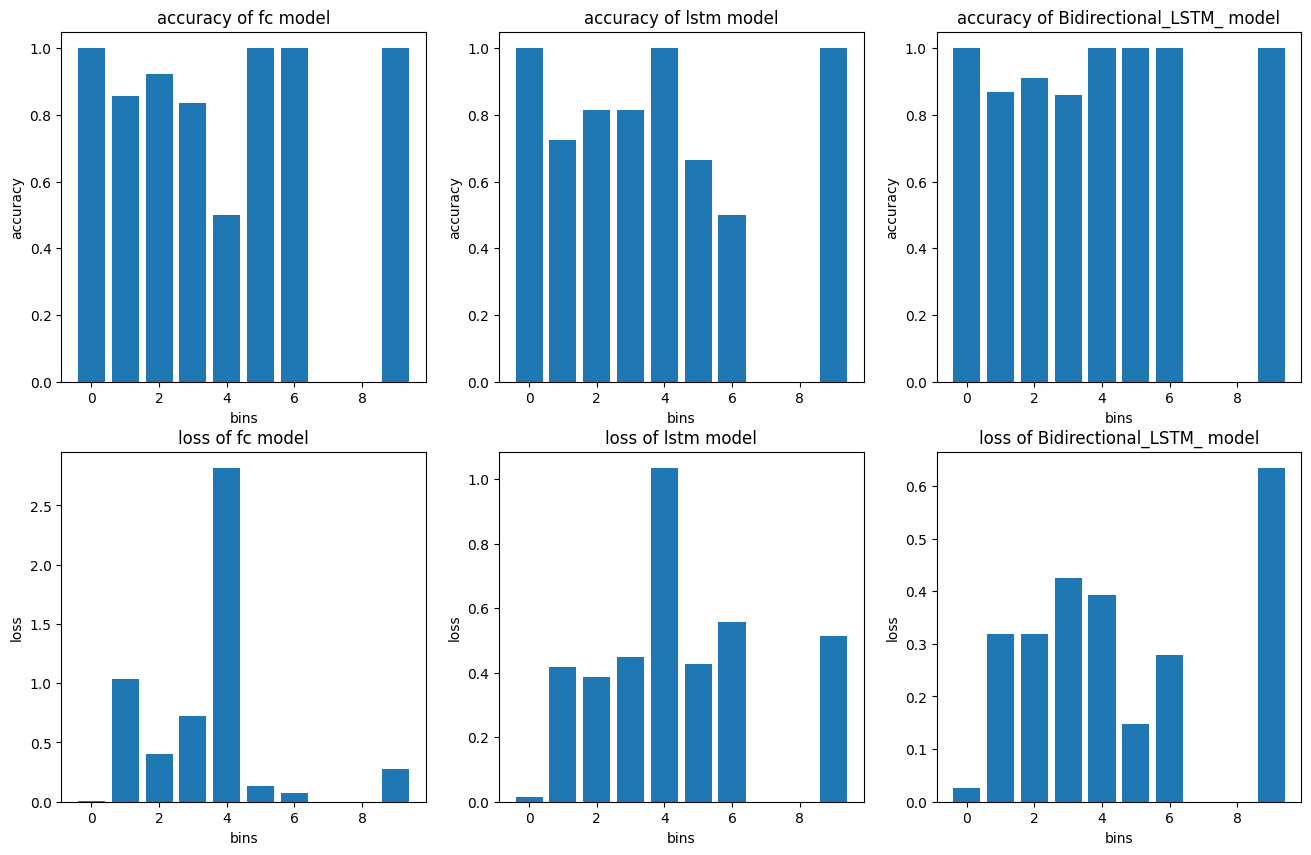

In [163]:
fig ,axes = plt.subplots(figsize=(16, 10),ncols=3,nrows=2)
axes[0,0].bar(range(len(acc_fc)),acc_fc)
axes[0,0].set_title('accuracy of fc model')
axes[0,0].set_xlabel('bins')
axes[0,0].set_ylabel('accuracy')
axes[1,0].bar(range(len(loss_fc)),loss_fc)
axes[1,0].set_title('loss of fc model')
axes[1,0].set_xlabel('bins')
axes[1,0].set_ylabel('loss')

axes[0,1].bar(range(len(acc_lstm)),acc_lstm)
axes[0,1].set_title('accuracy of lstm model')
axes[0,1].set_xlabel('bins')
axes[0,1].set_ylabel('accuracy')
axes[1,1].bar(range(len(loss_lstm)),loss_lstm)
axes[1,1].set_title('loss of lstm model')
axes[1,1].set_xlabel('bins')
axes[1,1].set_ylabel('loss')

axes[0,2].bar(range(len(acc_lstm)),acc_bilstm)
axes[0,2].set_title('accuracy of Bidirectional_LSTM_ model')
axes[0,2].set_xlabel('bins')
axes[0,2].set_ylabel('accuracy')
axes[1,2].bar(range(len(loss_lstm)),loss_bilstm)
axes[1,2].set_title('loss of Bidirectional_LSTM_ model')
axes[1,2].set_xlabel('bins')
axes[1,2].set_ylabel('loss')

As the sequence gets longer, regular LSTMs start to struggle because they tend to forget what they've learned before. On the other hand, bidirectional LSTMs perform more consistently as the sequences get longer. This is because they can analyze data both forward and backward, which helps them remember the beginning of the sequence even as they process further.

However, it's important to note that bidirectional LSTMs still have a risk of forgetting information from the middle of the sequence.

One big problem with this homework analysis is that there's not enough data to work with. Because of this, it's hard to trust if the results are accurate.

For example, we noticed a small drop in accuracy in the fully connected (FC) network. This doesn't really make sense based on what we know, and it could be because we just don't have enough data.
